This notebook serves as an example of how to load and manipulate the [QM9 dataset](https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904) using a `Dataset` object.

# Imports

In [1]:
import os
import numpy as np

from ase import Atoms

# Initialize the `HDF5Client`

In [2]:
from colabfit.tools.database import MongoDatabase

client = MongoDatabase('qm9', nprocs=6)#, drop=True)

# Data loading

## Define the properties and reader functions

In [3]:
client.insert_property_definition({
    'property-id': 'qm9-property',
    'property-title': 'A, B, C, mu, alpha, homo, lumo, gap, r2, zpve, U0, U, H, G, Cv',
    'property-description': 'Geometries minimal in energy, corresponding harmonic frequencies, dipole moments, polarizabilities, along with energies, enthalpies, and free energies of atomization',
    'a':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Rotational constant A'},
    'b':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Rotational constant B'},
    'c':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Rotational constant C'},
    'mu':    {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Dipole moment'},
    'alpha': {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Isotropic polarizability'},
    'homo':  {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Energy of Highest occupied molecular orbital (HOMO)'},
    'lumo':  {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Energy of Lowest occupied molecular orbital (LUMO)'},
    'gap':   {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Gap, difference between LUMO and HOMO'},
    'r2':    {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Electronic spatial extent'},
    'zpve':  {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Zero point vibrational energy'},
    'u0':    {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Internal energy at 0 K'},
    'u':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Internal energy at 298.15 K'},
    'h':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Enthalpy at 298.15 K'},
    'g':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Free energy at 298.15 K'},
    'cv':    {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Heat capacity at 298.15 K'},
    'smiles-relaxed':    {'type': 'string', 'has-unit': False, 'extent': [], 'required': True, 'description': 'SMILES for relaxed geometry'},
    'inchi-relaxed':     {'type': 'string', 'has-unit': False, 'extent': [], 'required': True, 'description': 'InChI for relaxed geometry'},
})

/home/jvita/scripts/colabfit-tools/colabfit/tools/database.py:547: UserWarning: Invalid KIM property-id; Temporarily renaming to tag:@,0000-00-00:property/qm9-property
  warnings.warn(f"Invalid KIM property-id; Temporarily renaming to {dummy_dict['property-id']}")


In [4]:
client.get_property_definition('qm9-property')['definition']

{'property-id': 'qm9-property',
 'property-title': 'A, B, C, mu, alpha, homo, lumo, gap, r2, zpve, U0, U, H, G, Cv',
 'property-description': 'Geometries minimal in energy, corresponding harmonic frequencies, dipole moments, polarizabilities, along with energies, enthalpies, and free energies of atomization',
 'a': {'type': 'float',
  'has-unit': True,
  'extent': [],
  'required': True,
  'description': 'Rotational constant A'},
 'b': {'type': 'float',
  'has-unit': True,
  'extent': [],
  'required': True,
  'description': 'Rotational constant B'},
 'c': {'type': 'float',
  'has-unit': True,
  'extent': [],
  'required': True,
  'description': 'Rotational constant C'},
 'mu': {'type': 'float',
  'has-unit': True,
  'extent': [],
  'required': True,
  'description': 'Dipole moment'},
 'alpha': {'type': 'float',
  'has-unit': True,
  'extent': [],
  'required': True,
  'description': 'Isotropic polarizability'},
 'homo': {'type': 'float',
  'has-unit': True,
  'extent': [],
  'required

## Defining a `property_map`

In [5]:
property_map = {
    'qm9-property': {
        # Property Definition field: {'field': ASE field, 'units': ASE-readable units}
        'a':     {'field': 'A',     'units': 'GHz'},
        'b':     {'field': 'B',     'units': 'GHz'},
        'c':     {'field': 'C',     'units': 'GHz'},
        'mu':    {'field': 'mu',    'units': 'Debye'},
        'alpha': {'field': 'alpha', 'units': 'Bohr*Bohr*Bohr'},
        'homo':  {'field': 'homo',  'units': 'Hartree'},
        'lumo':  {'field': 'lumo',  'units': 'Hartree'},
        'gap':   {'field': 'gap',   'units': 'Hartree'},
        'r2':    {'field': 'r2',    'units': 'Bohr*Bohr'},
        'zpve':  {'field': 'zpve',  'units': 'Hartree'},
        'u0':    {'field': 'U0',    'units': 'Hartree'},
        'u':     {'field': 'U',     'units': 'Hartree'},
        'h':     {'field': 'H',     'units': 'Hartree'},
        'g':     {'field': 'G',     'units': 'Hartree'},
        'cv':    {'field': 'Cv',    'units': 'cal/mol/K'},
        'smiles-relaxed': {'field': 'SMILES_relaxed', 'units': None},
        'inchi-relaxed': {'field': 'SMILES_relaxed',  'units': None},
    }
}

In [6]:
def reader(file_path):
    # A function for returning a list of ASE a
    
    properties_order = [
        'tag', 'index', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv'
    ]
        
#     images = []
    with open(file_path, 'r') as f:
        lines = [_.strip() for _ in f.readlines()]
        
        na = int(lines[0])
        properties = lines[1].split()
        
        symbols = []
        positions = []
        partial_charges = []
        
        for line in lines[2:2+na]:
            split = line.split()
            split = [_.replace('*^', 'e') for _ in split]  # Python-readable scientific notation
            
            # Line order: symbol, x, y, z, charge
            symbols.append(split[0])
            positions.append(split[1:4])
            partial_charges.append(split[-1])
            
        positions = np.array(positions)
        partial_charges = np.array(partial_charges, dtype=float)
                
        atoms = Atoms(symbols=symbols, positions=positions)
        
        atoms.info['mulliken_partial_charges'] = partial_charges
        
        name = os.path.splitext(os.path.split(file_path)[-1])[0]

        atoms.info['name'] = name
        
        for pname, val in zip(properties_order[2:], properties[2:]):
            atoms.info[pname] = float(val)
            
        frequencies = np.array(lines[-3].split(), dtype=float)
        atoms.info['frequencies'] = frequencies
                
        smiles = lines[-2].split()
        inchi  = lines[-1].split()
        
        atoms.info['SMILES']    = smiles[0]
        atoms.info['SMILES_relaxed'] = smiles[1]
        atoms.info['InChI']     = inchi[0]
        atoms.info['InChI_relaxed']  = inchi[1]
        
        yield atoms
#         images.append(atoms)
    
#     return images

## Load and insert the data

In [7]:
from colabfit.tools.database import load_data

images = list(load_data(
    file_path='/home/jvita/scripts/colabfit/data/quantum-machine/qm9',
    file_format='folder',
    name_field='name',  # key in Configuration.info to use as the Configuration name
    elements=['H', 'C', 'N', 'O', 'F'],    # order matters for CFG files, but not others
    default_name='qm9',  # default name with `name_field` not found
    reader=reader,
    glob_string='*.xyz',
    verbose=True
))

Loading data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 139980/139980 [00:41<00:00, 3352.25it/s]


In [8]:
from colabfit.tools.property_settings import PropertySettings

pso = PropertySettings(
    method='DFT/B3LYP/6-31G(2df,p)',
    description='QM9 property settings calculation',
    files=None,
    labels=['DFT', 'B3LYP', '6-31G(2df,p)'],
)

ids = list(client.insert_data(
    images,
    property_map=property_map,
    property_settings={'qm9-property': pso},
    generator=False,
    verbose=True
))

/home/jvita/Programs/miniconda2/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
Adding configurations to Database:   0%|                                                                                                      | 0/23330 [00:00<?, ?it/s]/home/jvita/scripts/colabfit-tools/colabfit/tools/property.py:231: UserWarning: Invalid KIM property-id; Temporarily renaming to tag:@,0000-00-00:property/qm9-property
  warnings.warn(f"Invalid KIM property-id; Temporarily renaming to {dummy_dict['property-id']}")
Adding configurations to Database:   0%|                                                                                                      | 0/23330 [

Writing configurations: 23330


Adding configurations to Database: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 23330/23330 [00:43<00:00, 535.52it/s]


Writing configurations: 23330


Adding configurations to Database: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 23330/23330 [00:43<00:00, 535.89it/s]


Writing configurations: 23330


Adding configurations to Database: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 23330/23330 [00:43<00:00, 535.28it/s]


Writing configurations: 23330


Adding configurations to Database:  98%|███████████████████████████████████████████████████████████████████████████████████████▍ | 22907/23330 [00:43<00:01, 349.67it/s]

Writing properties: 23330


Adding configurations to Database: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 23330/23330 [00:43<00:00, 537.57it/s]


Writing configurations: 23330


Adding configurations to Database: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 23330/23330 [00:44<00:00, 521.13it/s]


Writing configurations: 23330
Writing properties: 23330
Writing properties: 23330
Writing properties: 23330
Writing property settings: 1
Closing client
Writing property settings: 1
Closing client
Writing properties: 23330
Writing property settings: 1
Closing client
Writing property settings: 1
Closing client
Writing properties: 23330
Writing property settings: 1
Closing client
Writing property settings: 1
Closing client


Two configurations are found to be in both `dsC7O2H10nsd` and `dsgdb9nsd`

In [9]:
list(client.configurations.find({'relationships.properties.1': {'$exists': True}}, {'relationships.properties': 1, 'names': 1}))

[{'_id': '3656036745970248267',
  'names': ['dsC7O2H10nsd_0776', 'dsgdb9nsd_047894'],
  'relationships': {'properties': ['6351269288171772275',
    '-7370643985298096902']}},
 {'_id': '-3845410279001134360',
  'names': ['dsC7O2H10nsd_0290', 'dsgdb9nsd_039272'],
  'relationships': {'properties': ['-1012785745585825691',
    '-3373684799434833296']}}]

And three pairs of properties have the exact same values even though they point to different configurations

In [33]:
duplicates = list(client.properties.find(
    {'relationships.configurations.1': {'$exists': True}},
    {'relationships.configurations': 1, 'qm9-property.a': 1}
))
duplicates

[{'_id': '3286736804441236333',
  'qm9-property': {'a': {'source-value': [3.88552], 'source-unit': 'GHz'}},
  'relationships': {'configurations': ['8272864698912355576',
    '-5879116620246917160']}},
 {'_id': '4598603241229063945',
  'qm9-property': {'a': {'source-value': [2.00786], 'source-unit': 'GHz'}},
  'relationships': {'configurations': ['4310862637114836733',
    '-6592784900130366119']}},
 {'_id': '2966534541301994245',
  'qm9-property': {'a': {'source-value': [1.92237], 'source-unit': 'GHz'}},
  'relationships': {'configurations': ['1801916042308215165',
    '3003568598417691727']}}]

In [36]:
for dup in duplicates:
    print(dup['qm9-property']['a'], [co['names'] for co in client.configurations.find({'_id': {'$in': dup['relationships']['configurations']}})])

{'source-value': [3.88552], 'source-unit': 'GHz'} [['dsgdb9nsd_007699'], ['dsgdb9nsd_004272']]
{'source-value': [2.00786], 'source-unit': 'GHz'} [['dsgdb9nsd_027847'], ['dsgdb9nsd_027385']]
{'source-value': [1.92237], 'source-unit': 'GHz'} [['dsgdb9nsd_027381'], ['dsgdb9nsd_027844']]


# Defining `ConfigurationSet`s

In [3]:
co_ids1 = [_['_id'] for _ in client.configurations.find({'names': {'$regex': 'dsC7O2H10nsd'}}, {'_id': 1})]
co_ids2 = [_['_id'] for _ in client.configurations.find({'names': {'$regex': 'dsgdb9nsd'}}, {'_id': 1})]

print('Database 1', '(dsC7O2H10nsd):'.rjust(15), f'{len(co_ids1)}'.rjust(7))
print('Database 2', '(dsgdb9nsd):'.rjust(15), f'{len(co_ids2)}'.rjust(7))

Database 1 (dsC7O2H10nsd):    6095
Database 2    (dsgdb9nsd):  133885


In [4]:
cs_id1 = client.insert_configuration_set(
    co_ids1,
    description='Isomers of C7O2H10'
)
cs_id1

'-2437119122457883750'

In [5]:
cs_id2 = client.insert_configuration_set(
    co_ids2,
    description='The subset of all 133,885 species with up to '\
    'nine heavy atoms (CONF) out of the GDB-17 chemical universe '\
    'of 166 billion organic molecules'
)
cs_id2

'2955061802318442107'

In [6]:
cs1 = client.get_configuration_set(cs_id1)['configuration_set']

print(cs1.description)

for k,v in cs1.aggregated_info.items():
    print(k, v)

Isomers of C7O2H10
nconfigurations 6095
nsites 115805
nelements 3
elements ['C', 'H', 'O']
individual_elements_ratios [[0.37], [0.53], [0.11]]
total_elements_ratios [0.3684210526315789, 0.5263157894736842, 0.10526315789473684]
labels []
labels_counts []
chemical_formula_reduced ['C7H10O2']
chemical_formula_anonymous ['A10B7C2']
chemical_formula_hill ['C7H10O2']
nperiodic_dimensions [0]
dimension_types [[0, 0, 0]]


In [7]:
cs2 = client.get_configuration_set(cs_id2)['configuration_set']

print(cs2.description)

for k,v in cs2.aggregated_info.items():
    print(k, v)

The subset of all 133,885 species with up to nine heavy atoms (CONF) out of the GDB-17 chemical universe of 166 billion organic molecules
nconfigurations 133885
nsites 2407753
nelements 5
elements ['C', 'H', 'N', 'O', 'F']
individual_elements_ratios [[0.33, 0.36, 0.43, 0.32, 0.35, 0.38, 0.28, 0.37, 0.3, 0.31, 0.25, 0.42, 0.5, 0.67, 0.75, 0.26, 0.18, 0.6, 0.11, 0.27, 0.69, 0.44, 0.19, 0.53, 0.7, 0.78, 0.2, 0.45, 0.62, 0.12, 0.29, 0.21, 0.15, 0.23, 0.22, 0.54, 0.46, 0.17, 0.1, 0.09, 0.71, 0.47, 0.55, 0.8, 0.39, 0.14, 0.64, 0.56, 0.4, 0.57, 0.24, 0.41, 0.58], [0.5, 0.36, 0.6, 0.53, 0.57, 0.44, 0.47, 0.55, 0.64, 0.43, 0.42, 0.59, 0.25, 0.67, 0.75, 0.18, 0.11, 0.27, 0.69, 0.61, 0.7, 0.2, 0.45, 0.62, 0.12, 0.29, 0.1, 0.54, 0.71, 0.22, 0.17, 0.46, 0.38, 0.63, 0.3, 0.8, 0.14, 0.31, 0.56, 0.73, 0.4, 0.65, 0.58, 0.33], [0.06, 0.12, 0.19, 0.14, 0.31, 0.07, 0.25, 0.42, 0.24, 0.45, 0.5, 0.67, 0.75, 0.18, 0.43, 0.6, 0.35, 0.11, 0.05, 0.27, 0.44, 0.36, 0.04, 0.28, 0.2, 0.62, 0.29, 0.21, 0.17, 0.1, 0.

# Defining `Dataset`s

In [7]:
pr_ids = [_['_id'] for _ in client.properties.find({}, {'_id': 1})]
len(pr_ids)

139977

In [8]:
ds_id = client.insert_dataset(
    cs_ids=[cs_id1, cs_id2],
    pr_ids=pr_ids,
    authors=['Raghunathan Ramakrishnan', 'Pavlo Dral', 'Matthias Rupp', 'O. Anatole von Lilienfeld'],
    links=[
        'https://www.nature.com/articles/sdata201422',
        'https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904'
    ],
    description="The QM9 dataset, split into the GDB-9 molecules and the C7O2H10 isomers",
    resync=True,
    verbose=True,
)
ds_id

'-2841240401828981909'

In [3]:
ds_id = '-2841240401828981909'
dsdoc = next(client.datasets.find({'_id': ds_id}))

for k,v in dsdoc['aggregated_info'].items():
    print(k,v)

nconfigurations 139978
nsites 2523520
nelements 5
elements ['C', 'H', 'N', 'O', 'F']
individual_elements_ratios [[0.33, 0.36, 0.43, 0.32, 0.35, 0.38, 0.28, 0.37, 0.3, 0.31, 0.25, 0.42, 0.5, 0.67, 0.75, 0.26, 0.18, 0.6, 0.11, 0.27, 0.69, 0.44, 0.19, 0.53, 0.7, 0.78, 0.2, 0.45, 0.62, 0.12, 0.29, 0.21, 0.15, 0.23, 0.22, 0.54, 0.46, 0.17, 0.1, 0.09, 0.71, 0.47, 0.55, 0.8, 0.39, 0.14, 0.64, 0.56, 0.4, 0.57, 0.24, 0.41, 0.58], [0.5, 0.36, 0.6, 0.53, 0.57, 0.44, 0.47, 0.55, 0.64, 0.43, 0.42, 0.59, 0.25, 0.67, 0.75, 0.18, 0.11, 0.27, 0.69, 0.61, 0.7, 0.2, 0.45, 0.62, 0.12, 0.29, 0.1, 0.54, 0.71, 0.22, 0.17, 0.46, 0.38, 0.63, 0.3, 0.8, 0.14, 0.31, 0.56, 0.73, 0.4, 0.65, 0.58, 0.33], [0.06, 0.12, 0.19, 0.14, 0.31, 0.07, 0.25, 0.42, 0.24, 0.45, 0.5, 0.67, 0.75, 0.18, 0.43, 0.6, 0.35, 0.11, 0.05, 0.27, 0.44, 0.36, 0.04, 0.28, 0.2, 0.62, 0.29, 0.21, 0.17, 0.1, 0.15, 0.09, 0.46, 0.23, 0.22, 0.16, 0.13, 0.38, 0.3, 0.55, 0.8, 0.64, 0.08, 0.56, 0.4, 0.57, 0.58, 0.33], [0.12, 0.06, 0.07, 0.18, 0.19, 0.2

# Exploration

In [6]:
print(client.get_statistics('qm9-property.a', verbose=True))
print(client.get_statistics('qm9-property.b', verbose=True))
print(client.get_statistics('qm9-property.c', verbose=True))

Getting data: 139977it [00:08, 16647.32it/s]


{'average': 9.517265441015311, 'std': 1769.6463403282503, 'min': 0.0, 'max': 619867.68314, 'average_abs': 9.517265441015311}


Getting data: 139977it [00:08, 17025.19it/s]


{'average': 1.4058116563171092, 'std': 1.5507007180932222, 'min': 0.33712, 'max': 437.90386, 'average_abs': 1.4058116563171092}


Getting data: 139977it [00:08, 16848.16it/s]


{'average': 1.1257355705437322, 'std': 1.0729683700101622, 'min': 0.33118, 'max': 282.94545, 'average_abs': 1.1257355705437322}


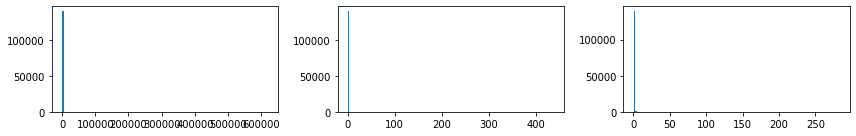

In [7]:
client.plot_histograms([
    'qm9-property.a',
    'qm9-property.b',
    'qm9-property.c',
])

Results of running command:

`dataset.plot_histograms(['a', 'b', 'c', 'mu', 'alpha', 'homo', 'lumo', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv'])`

[QM9 histograms (original)](https://github.com/colabfit/colabfit-tools/blob/master/colabfit/examples/qm9_histograms.png)

In [4]:
clean_config_sets, clean_property_ids = client.filter_dataset(
    ds_id=ds_id,
    collection_name='properties',
    query={'qm9-property.a.source-value': {'$lt': 20}, 'qm9-property.b.source-value': {'$lt': 10}},
    verbose=True
)

Filtering on properties: 139871it [00:01, 77865.36it/s] 
Aggregating configuration info: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 133779/133779 [00:15<00:00, 8751.77it/s]


In [11]:
new_cs_ids = []
for cs in clean_config_sets:
    new_cs_ids.append(client.insert_configuration_set(cs.configuration_ids, cs.description, verbose=True))
    
print(new_cs_ids)

['-2437119122457883750', '6209309880516360860']


In [12]:
ds_id_clean = client.insert_dataset(
    cs_ids=new_cs_ids,
    pr_ids=clean_property_ids,
    authors=['Josh Vita'],
    links=[
        'https://www.nature.com/articles/sdata201422',
        'https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904'
    ],
    description="The QM9 dataset, filtered by removing values with a>=20 or b>=10",
    resync=True,
    verbose=True,
)
ds_id_clean

'546584693795004874'

In [13]:
clean_ds = client.get_dataset(ds_id_clean)['dataset']
len(clean_ds.property_ids)

139871

Getting data: 139871it [00:09, 14181.90it/s]
Getting data: 139871it [00:09, 14522.48it/s]
Getting data: 139871it [00:09, 14276.92it/s]


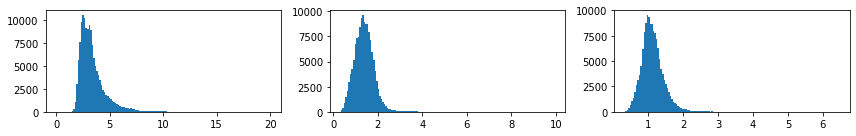

In [14]:
client.plot_histograms(
    [
        'qm9-property.a',
        'qm9-property.b',
        'qm9-property.c',
    ],
    ids=clean_ds.property_ids,
    verbose=True
)